In [48]:
%reload_ext autoreload
%autoreload 2

In [25]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import json
from graph_utils import pickle_model,load_pickle_model

In [3]:
from sklearn.cluster import MiniBatchKMeans, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [123]:
RANDOM_SEED = 1337
MODEL_PICKLE_PATH = 'ModelPickles/'

In [5]:
full_data = pd.read_csv('Dataset/clean_data.csv',index_col='customerID')
churn = full_data['Churn'].copy()
full_data = full_data.drop('Churn',axis=1)

# Preprocessing

In [6]:
#Separate data for training and testing with 80% for training and 20% testing
#Uses our preselected random seed to results are reproducible 
raw_x_train, raw_x_test, y_train, y_test = train_test_split(
    full_data,
    churn,
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [7]:
# These are the internet related services we found during EDA
serv_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
             'TechSupport','StreamingTV', 'StreamingMovies']

We will use several different algorithms then compare their performance afterwards to determine which is the best to use. The algorithm we will use are: 
- Logistic Regression
- K Nearest Neighbor Classifier
- Random Forest
- XGBoost
- LightGBM

## Pipelines

In [11]:
from pipeline_factory import PipelineFactory

In [12]:
pf = PipelineFactory(raw_x_train)

In [414]:
log_pipe = pf.create_pipe(
    counted_services=serv_cols, engineer=True,
    random_seed = RANDOM_SEED, normalize=True
)

log_x_train = log_pipe.fit_transform(raw_x_train)
log_x_test = log_pipe.transform(raw_x_test)

In [14]:
tree_pipe = pf.create_pipe(
    counted_services=serv_cols, engineer=True,
    random_seed = RANDOM_SEED, normalize=False
)

tree_x_train = tree_pipe.fit_transform(raw_x_train)
tree_x_test = tree_pipe.transform(raw_x_test)

# Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from graph_utils import graph_cv_results

In [16]:
from sklearn.metrics import ( 
    RocCurveDisplay,
    ConfusionMatrixDisplay,
) 
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [415]:
log_reg = LogisticRegression(
    random_state=RANDOM_SEED,
    class_weight='balanced',
    solver='saga',
    penalty='elasticnet',
    max_iter=5000
)

In [441]:
log_grid_cv = GridSearchCV(
    log_reg,
    param_grid={
        'l1_ratio':[0,0.2,0.4,0.6,0.8,1],
        'C':[1,10]
    },
    scoring='roc_auc',cv=5)
log_grid_cv.fit(log_x_train,y_train)

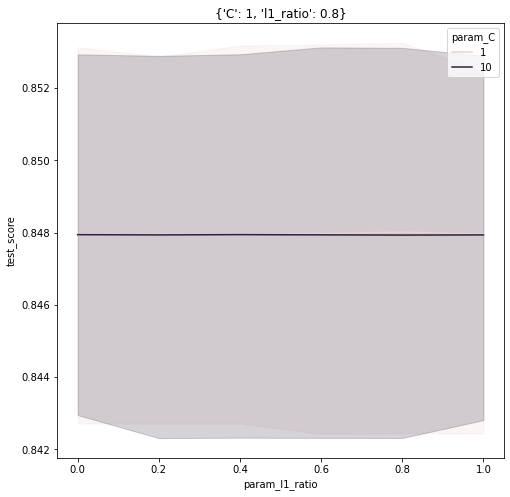

In [321]:
graph_cv_results(log_grid_cv,x='param_l1_ratio',hue='param_C')

In [199]:
pickle_model(log_reg,MODEL_PICKLE_PATH+'log_reg')

# K Nearest Neighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [419]:
knn = KNeighborsClassifier()

In [420]:
knn_grid_cv = GridSearchCV(
    knn,
    {
        'n_neighbors':range(10,100,5),
        'weights':['uniform','distance']
    },
    scoring='roc_auc',cv=5)
knn_grid_cv.fit(log_x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 100, 5),
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

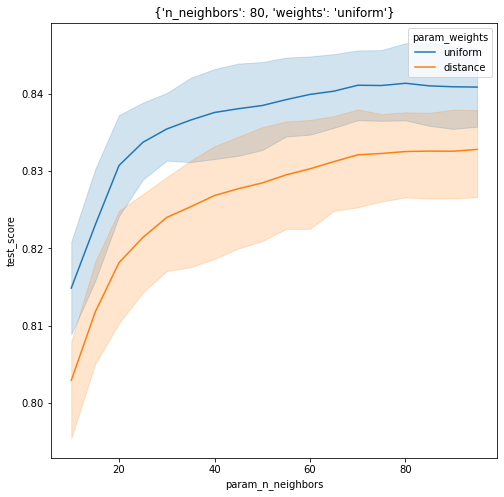

In [421]:
graph_cv_results(knn_grid_cv,x='param_n_neighbors',hue='param_weights')

In [423]:
pickle_model(knn_grid_cv,MODEL_PICKLE_PATH+'knn_grid_cv')

# Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rfc = RandomForestClassifier(random_state=RANDOM_SEED,class_weight='balanced')

In [106]:
rfc_grid_cv = GridSearchCV(
    rfc,
    {
        'n_estimators':range(80,120,10),
        'min_samples_split':range(6,10)
    },
    scoring='roc_auc',cv=5)
rfc_grid_cv.fit(tree_x_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1337),
             param_grid={'min_samples_split': range(6, 10),
                         'n_estimators': range(80, 120, 10)},
             scoring='roc_auc')

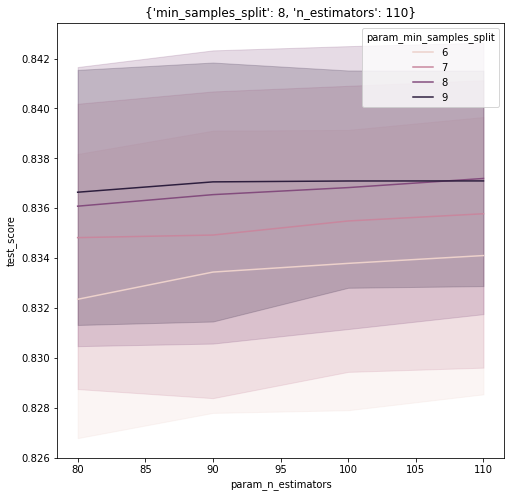

In [109]:
graph_cv_results(rfc_grid_cv,x='param_n_estimators',hue='param_min_samples_split')

In [125]:
pickle_model(rfc_grid_cv,MODEL_PICKLE_PATH+'rfc_grid_cv')

# XGBoost

In [218]:
from xgboost import XGBClassifier

In [379]:
xgbClf = XGBClassifier(
    gamma=0,
    objective= 'binary:logistic',
    importance_type='gain',
    nthread=4,
    seed=RANDOM_SEED
)

In [430]:
xgb_grid_cv = GridSearchCV(
    xgbClf,
    param_grid={
        'learning_rate':[0.1,0.3],
        'n_estimators':[10,15,20],
        'min_child_weight':[1,2,3],
        'max_depth':[3,4,5,6],
        'scale_pos_weight':[1,np.bincount(y_train)[0]
                            /np.bincount(y_train)[1]],
    },
    scoring='roc_auc',cv=5)
xgb_grid_cv.fit(tree_x_train,y_train)

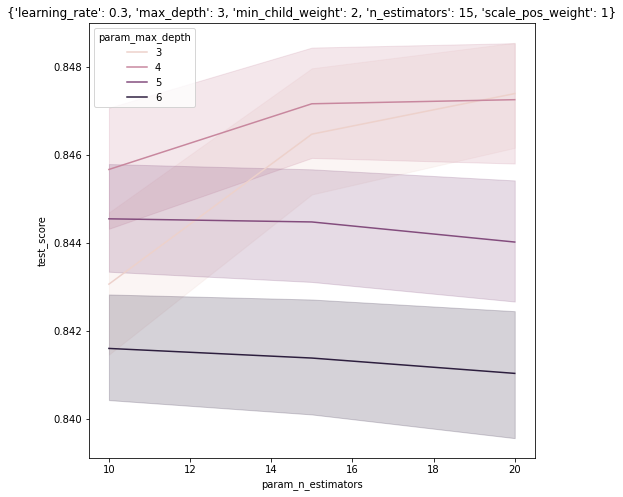

In [386]:
graph_cv_results(xgb_grid_cv,x='param_n_estimators',hue='param_max_depth')

In [391]:
pickle_model(xgb_grid_cv,MODEL_PICKLE_PATH+'xgb_grid_cv')

# LightGBM

In [150]:
from lightgbm import LGBMClassifier

In [152]:
lgbm = LGBMClassifier(
    learning_rate = 0.1,
    objective= 'binary',
    class_weight='balanced',
    seed=RANDOM_SEED
)

In [160]:
lgbm_grid_cv = GridSearchCV(
    lgbm,
    param_grid={
        'n_estimators':[5,10,15,20],
        'num_leaves':[20,25,30,35,40,45],
        'colsample_bytree':[0.9,1],
        'subsample':[0.9,1],
    },
    scoring='roc_auc',cv=5)
lgbm_grid_cv.fit(tree_x_train,y_train)

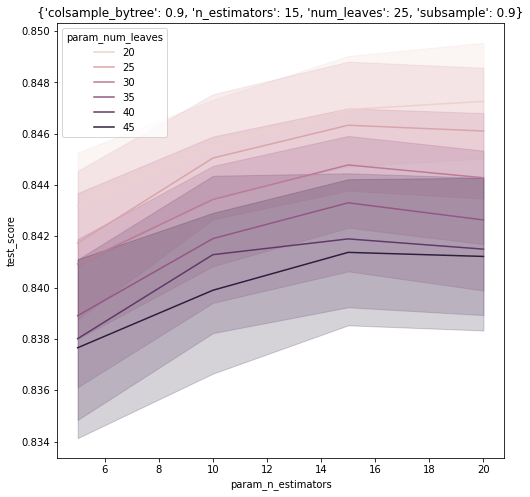

In [413]:
graph_cv_results(lgbm_grid_cv,x='param_n_estimators',hue='param_num_leaves')

In [161]:
pickle_model(lgbm_grid_cv,MODEL_PICKLE_PATH+'lgbm_grid_cv')

# Model Comparisons

Text(0.5, 1.0, 'KNeighbors 0.8250628205392267')

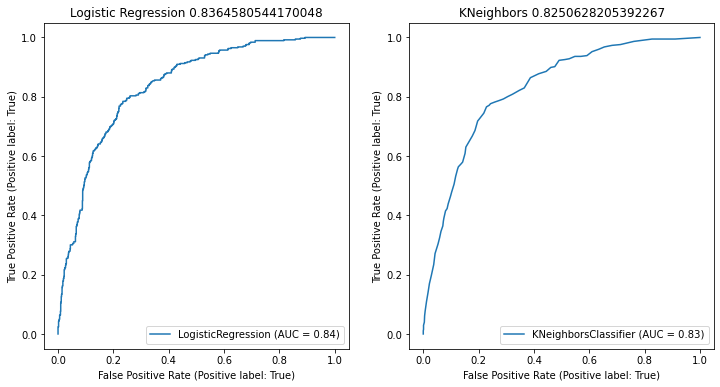

In [436]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
RocCurveDisplay.from_estimator(
    log_grid_cv.best_estimator_,
    log_x_test,y_test,ax=ax[0])
ax[0].set_title(f'Logistic Regression {roc_auc_score(y_test,log_grid_cv.best_estimator_.predict_proba(log_x_test)[:,1])}')
RocCurveDisplay.from_estimator(
    knn_grid_cv.best_estimator_,
    log_x_test,y_test,ax=ax[1])
ax[1].set_title(f'KNeighbors {roc_auc_score(y_test,knn_grid_cv.best_estimator_.predict_proba(log_x_test)[:,1])}')

Text(0.5, 1.0, 'LightGBM 0.8326965459001875')

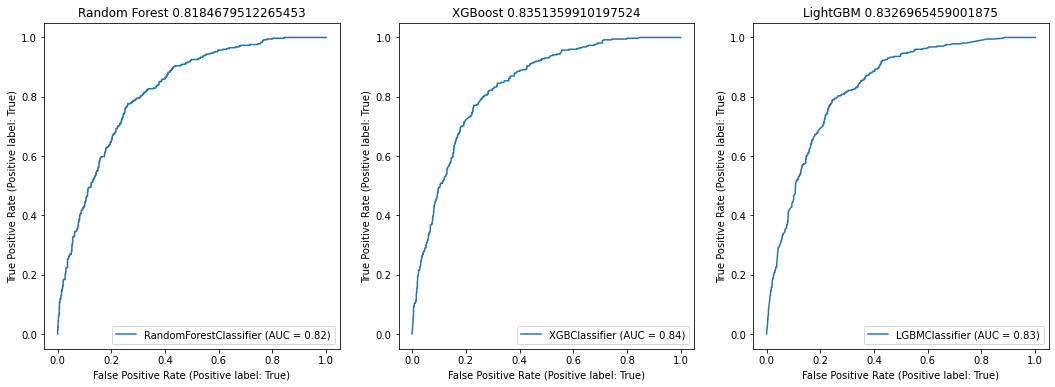

In [390]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
RocCurveDisplay.from_estimator(rfc_grid_cv.best_estimator_,
                               tree_x_test,y_test,ax=ax[0])
ax[0].set_title(f'Random Forest {roc_auc_score(y_test,rfc_grid_cv.best_estimator_.predict_proba(tree_x_test)[:,1])}')
RocCurveDisplay.from_estimator(xgb_grid_cv.best_estimator_,
                               tree_x_test,y_test,ax=ax[1])
ax[1].set_title(f'XGBoost {roc_auc_score(y_test,xgb_grid_cv.best_estimator_.predict_proba(tree_x_test)[:,1])}')
RocCurveDisplay.from_estimator(lgbm_grid_cv.best_estimator_,
                               tree_x_test,y_test,ax=ax[2])
ax[2].set_title(f'LightGBM {roc_auc_score(y_test,lgbm_grid_cv.best_estimator_.predict_proba(tree_x_test)[:,1])}')

# Examining Features

In [424]:
pd.Series(abs(log_grid_cv.best_estimator_.coef_.flatten()),index=log_pipe.get_feature_names_out()).sort_values(ascending=False).head(10)

KMeansCluster4             1.557969
Contract_Two year          1.359150
tenure                     1.267436
TotalCharges               1.210917
KMeansCluster2             1.009463
KMeansCluster1             0.910154
Contract_Month-to-month    0.888713
InternetService_No         0.876130
KMeansCluster7             0.852702
internetServicesSubbed     0.464612
dtype: float64

In [408]:
pd.Series(xgb_grid_cv.best_estimator_.feature_importances_,index=tree_pipe.get_feature_names_out()).sort_values(ascending=False).head(10)

Contract_Month-to-month           0.404834
InternetService_Fiber optic       0.113930
InternetService_No                0.050281
tenure                            0.041383
Contract_Two year                 0.040353
OnlineSecurity                    0.037248
TotalCharges                      0.036353
PaymentMethod_Electronic check    0.034931
PaperlessBilling                  0.033275
PhoneService                      0.024625
dtype: float32

In [409]:
pd.Series(lgbm_grid_cv.best_estimator_.feature_importances_,index=tree_pipe.get_feature_names_out()).sort_values(ascending=False).head(10)

tenure                            61
MonthlyCharges                    57
KMeansCluster0                    22
PaymentMethod_Electronic check    20
InternetService_Fiber optic       17
KMeansCluster4                    15
Contract_One year                 15
PaperlessBilling                  13
KMeansCluster7                    12
OnlineSecurity                    12
dtype: int32

# Stacking Classifier

In [221]:
from sklearn.ensemble import StackingClassifier

In [217]:
stack_pipe = pf.create_pipe(
    counted_services=serv_cols, engineer=True,
    random_seed = RANDOM_SEED, normalize=True
)

stack_x_train = stack_pipe.fit_transform(raw_x_train)
stack_x_test = stack_pipe.transform(raw_x_test)

In [256]:
estimators = [
    ('log',LogisticRegression(**log_grid_cv.best_estimator_.get_params())),
    ('knn',KNeighborsClassifier(**knn_grid_cv.best_estimator_.get_params())),
    ('rfc',RandomForestClassifier(**rfc_grid_cv.best_estimator_.get_params())),
    ('xgb',XGBClassifier(**xgb_grid_cv.best_estimator_.get_params())),
    ('lgbm',LGBMClassifier(**lgbm_grid_cv.best_estimator_.get_params()))
]

In [286]:
final_estimator = LogisticRegression(
    random_state=RANDOM_SEED,
    class_weight='balanced',
    solver='saga',
    max_iter=5000
)

In [287]:
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator
)

In [288]:
stack_clf.fit(stack_x_train,y_train)

StackingClassifier(estimators=[('log',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   l1_ratio=0.8, max_iter=5000,
                                                   penalty='elasticnet',
                                                   random_state=1337,
                                                   solver='saga')),
                               ('knn', KNeighborsClassifier(n_neighbors=95)),
                               ('rfc',
                                RandomForestClassifier(class_weight='balanced',
                                                       min_samples_split=8,
                                                       n_estimators=110,
                                                       random_state=1337)),
                               ('xgb',
                                XGBClassifier(base_s...
                                              n_estimators=15, n_jobs=0,
                                              num_parallel_tree=1,
                                              predictor='auto', random_state=0,
                                              reg_alpha=0, reg_lambda=1, ...)),
                               ('lgbm',
                                LGBMClassifier(class_weight='balanced',
                                               colsample_bytree=0.9,
                                               n_estimators=15, num_leaves=25,
                                               objective='binary', seed=1337,
                                               subsample=0.9))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=5000,
                                                      random_state=1337,
                                                      solver='saga'))

In [ ]:
pickle_model(stack_clf,MODEL_PICKLE_PATH+'stack_clv')

Text(0.5, 1.0, 'Logistic 0.8375780107515808')

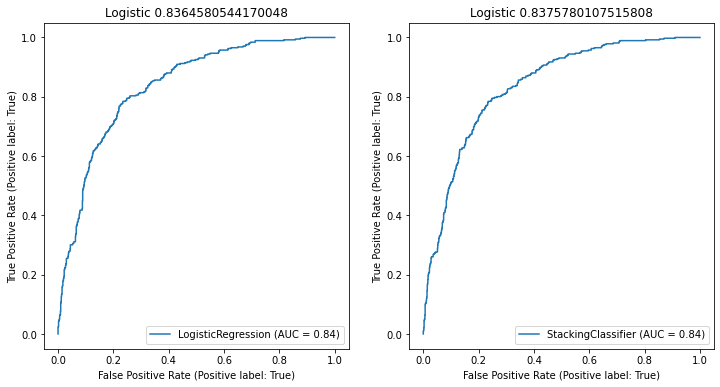

In [437]:

fig, ax = plt.subplots(1,2,figsize=(12,6))
RocCurveDisplay.from_estimator(
    log_grid_cv.best_estimator_,
    log_x_test,y_test,ax=ax[0]
)
ax[0].set_title(f'Logistic {roc_auc_score(y_test,log_grid_cv.best_estimator_.predict_proba(log_x_test)[:,1])}')
RocCurveDisplay.from_estimator(
    stack_clf,
    stack_x_test,y_test,ax=ax[1]
)
ax[1].set_title(f'Stacked Classifier {roc_auc_score(y_test,stack_clf.predict_proba(log_x_test)[:,1])}')

Text(0.5, 1.0, 'Stacked Classifier')

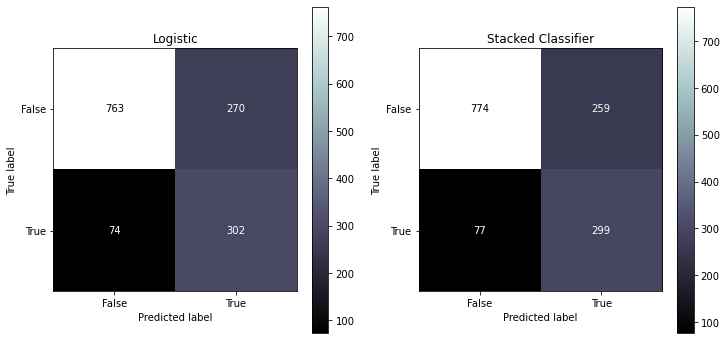

In [440]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ConfusionMatrixDisplay.from_estimator(
    log_grid_cv.best_estimator_,
    log_x_test,y_test,
    ax=ax[0],cmap='bone'
)
ax[0].set_title(f'Logistic')
ConfusionMatrixDisplay.from_estimator(
    stack_clf,
    stack_x_test,y_test,
    ax=ax[1],cmap='bone'
)
ax[1].set_title(f'Stacked Classifier')